# EMNIST

EMNIST es una extensión a MNIST donde involucra varios *datasets*, incluyendo la clasificación de caracteres alfabéticos. Es un problema intrínsecamente difícil, los mejores modelos no llegan a 96% según https://paperswithcode.com/sota/image-classification-on-emnist-letters. Además, es un problema práctico, puesto que es importante poder leer manuscritos a mano. Vamos a crear un modelo que pueda resolver, aunque no llegue al 96%.


In [3]:
from keras.utils import to_categorical
import keras
from keras import layers
from scipy import io as spio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import EarlyStopping


2025-06-25 14:57:40.777809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750885060.795879  123729 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750885060.801167  123729 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750885060.815399  123729 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750885060.815420  123729 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750885060.815422  123729 computation_placer.cc:177] computation placer alr

Cargamos el conjunto de datos, de la siguiente forma.

In [4]:
emnist = spio.loadmat('./datasets/emnist/emnist-letters.mat')

X_train = emnist['dataset'][0][0][0][0][0][0]
X_train = X_train.astype('float32')
y_train = emnist["dataset"][0][0][0][0][0][1]

X_test = emnist["dataset"][0][0][1][0][0][0]
X_test = X_test.astype('float32')

y_test = emnist["dataset"][0][0][1][0][0][1]

X_train = X_train.reshape(124800,28,28,1)
X_test = X_test.reshape(20800,28,28,1)


X_train = X_train / 255.0
X_test  = X_test / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Ahora visualizamos los datos.

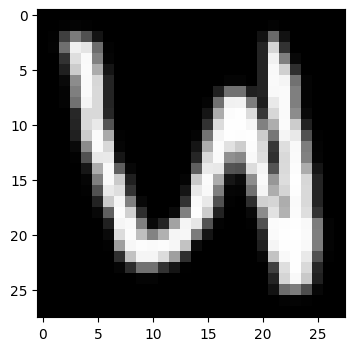

In [5]:
plt.figure(figsize=(4,4))
plt.imshow(np.rot90(X_train[4,:,:,0], k=3),cmap='gray')
plt.show()

In [6]:
len(y_train[1])

27

**Ejercicio**: Crea un red neuronal convolucional que clasifique las imágenes y mide la exactitud de la misma.

In [7]:
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(y_train[0]), activation="softmax"),
    ]
)

model.summary()

I0000 00:00:1750885072.224579  123729 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7573 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0b:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,930,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,092,187 (30.87 MB)

 Trainable params: 8,092,187 (30.87 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [9]:
results = model.fit(
    X_train,y_train,
    batch_size=128,
    epochs=50,
    callbacks=[early_stop],
    validation_data=(X_test,y_test))

Epoch 1/50


I0000 00:00:1750885078.140375  124052 service.cc:152] XLA service 0x7cea300108d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750885078.140392  124052 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-25 14:57:58.171516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750885078.346555  124052 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-25 14:57:58.924977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_370', 8 bytes spill stores, 8 bytes spill loads

2025-06-25 14:57:59.333335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_370', 48

 27/975 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2517 - loss: 2.6260

I0000 00:00:1750885083.179923  124052 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


974/975 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7989 - loss: 0.6648

2025-06-25 14:58:10.625930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 8 bytes spill stores, 8 bytes spill loads

2025-06-25 14:58:10.920935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98_0', 348 bytes spill stores, 348 bytes spill loads

2025-06-25 14:58:11.015395: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 128 bytes spill stores, 128 bytes spill loads

2025-06-25 14:58:11.028271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 484 bytes spill stores, 484 bytes spill loads

2025-06-25 14:58:11.062193: I external/loc

975/975 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7991 - loss: 0.6642 - val_accuracy: 0.9290 - val_loss: 0.2204
Epoch 2/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9387 - loss: 0.1767 - val_accuracy: 0.9299 - val_loss: 0.2070
Epoch 3/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9527 - loss: 0.1266 - val_accuracy: 0.9320 - val_loss: 0.2146
Epoch 4/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9625 - loss: 0.0968 - val_accuracy: 0.9359 - val_loss: 0.2069
Epoch 5/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9680 - loss: 0.0798 - val_accuracy: 0.9375 - val_loss: 0.2167
Epoch 6/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9734 - loss: 0.0666 - val_accuracy: 0.9359 - val_loss: 0.2478
Epoch 7/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9756 - loss: 0.0592 - val_accuracy: 0.9324 - val_loss: 0.2797
Epoch 8/50
975/975 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9779 - loss: 0.0515 - val_accuracy: 0.9334 - val

In [33]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9338 - loss: 0.2127
Test loss: 0.20686686038970947
Test accuracy: 0.9358654022216797


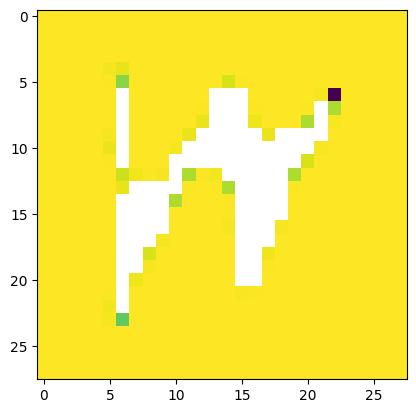

In [34]:
test_img = plt.imread('./datasets/emnist/w_letter.png')
test_img = cv2.resize(test_img,(28,28))
# test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
test_img = cv2.bitwise_not(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
plt.imshow(test_img)

In [35]:
test_img = test_img / 255.0
test_img = np.resize(test_img,(1,28,28,1))


In [38]:
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
prediction = model.predict(test_img, verbose=1)
print(prediction)
print(np.argmax(prediction))
print(f"Predicted value: {letters[np.argmax(prediction)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan]]
0
Predicted value: A
